# Linear Regression with Lasso (L1) Regularizer
In this notebook, I briefly introduce Lasso (L1) regularization and create a function that finds linear regression coefficients using L1 regularized least squares method. Then, I plot the cost function of Lasso regularized LS linear regression for univariate and bivariate case. The goal is to visualize the effect of the regularizer on the total cost function.

Prof. Nando de Freitas has a great machine learning course on youtube which includes a good explanation of Lasso regularization.

[CPSC 340 Undergraduate Machine Learning Course](https://youtube.com/playlist?list=PLE6Wd9FR--Ecf_5nCbnSQMHqORpiChfJf)

[Check my Github repository for similar introductory notebooks](https://github.com/YZouzou/ML-Topics-Intro)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import Ridge, Lasso
from ipywidgets import interact
import ipywidgets as widgets
plt.style.use('bmh')
# %matplotlib notebook

### Lasso (L1) Regularized LS Linear Regression:
We add an L1 regularizer to the cost function in order to penalize large $\theta$ values. By penalizing large theta values, our regression hyperplane will be less sensitive to some features and therefore we avoid overfitting.

**Regularized cost function:**
$$ J = (y - X\Theta)^{T}(y - X\Theta) + \delta^{2}\sum_{j=1}^d|\theta_{j}|$$

By manipulating the value of $\delta^{2}$ we can change the penalization degree for $\Theta$. By differentiating the previous cost function for $\Theta$ and equaling the derivative to zero we obtain the coefficients vector $\Theta$.

For detailed explanation on deriving this function: https://youtu.be/CjYz7z0usMo

### `lasso_regr`
This function calculates linear regression coefficients and intercept using an L1 regularized least squares cost function. The function first centers the data by substracting the mean from all data points. The intercept is calculated by substituting the coefficients and mean X and Y values in the regression hyperplane function, having the intercept as the only unknown variable.

This function takes in an initial value for coefficients ($\Theta$) and iteratively finds optimum $\theta$ values until the difference between every two successive $\theta$ values is less than the given tolerance.

**Ex:** First the optimum $\theta_{1}$ is calculated, given all other $\theta$s. Then, the optimum $\theta_{2}$ is calculated given all other thetas **having $\theta_{1}$ updated**. Iteration continues until the tolerance condition is satisfied.

`print_iter` Prints the number of iterations if set to `True`.

In [9]:
def lasso_regr(x, y, theta_init, delta, tolerance, print_iter = False):
    x_norm = x - x.mean(axis = 0)
    y_norm = y - y.mean(axis = 0)

    a = (1 / x.shape[0]) * np.sum(x_norm**2, axis = 0)

    i = 0
    theta = theta_init.copy()
    while True:
        theta_prev = theta.copy()
        for j in range(x.shape[1]):
            x_notj = np.delete(x_norm, j, 1)
            theta_notj = np.delete(theta, j, 0)

            cj = (1 / x.shape[0]) * np.sum((y_norm - x_notj @ theta_notj) * x_norm[:, j], axis = 0)

            if cj < -delta:
                theta_j = (cj + delta) / a[j]
            elif cj > delta:
                theta_j = (cj - delta) / a[j]
            else:
                theta_j = 0.
                
            theta[j] = theta_j
        i += 1
        if i > 1000:
            print('Number of iterations exceeded 1000')
            return False
        
        if all(np.abs(theta - theta_prev) < tolerance):
            if print_iter:
                print('Number of iterations: ', i)
            b = y.mean(axis = 0) - x.mean(axis = 0) @ theta
            return np.append(theta.flatten(), b)
        
    

### Comparison with Scikit-learn Lasso

Number of iterations:  2
My Lasso:
Coefficients =  [1.0896602]
Intercept =  2.8517682558872184

Scikit-learn Lasso:
Coefficients =  [1.0896602]
Intercept =  2.8517682558872184


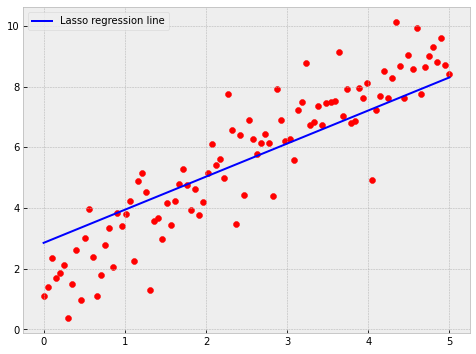

In [10]:
delta = 1
theta_init = np.random.randn(1)

x = np.linspace(0, 5, 100)
y_real = 1.5 * x + 2
y = y_real + np.random.randn(100)

theta = lasso_regr(x.reshape(-1, 1), y.flatten(), theta_init, delta = delta, tolerance = 0.00001, print_iter = True)
print('My Lasso:\nCoefficients = ', theta[:-1])
print('Intercept = ', theta[-1])

regr = Lasso(alpha = delta)
regr.fit(x.reshape(-1, 1), y.flatten())
print('\nScikit-learn Lasso:\nCoefficients = ', regr.coef_)
print('Intercept = ', regr.intercept_)

plt.close()
plt.figure(figsize = (8, 6))
plt.scatter(x, y, color = 'r')
plt.plot(x, regr.coef_*x + regr.intercept_, 'b', label = 'Lasso regression line')
plt.legend()
plt.show()

### Visualizing the Cost Function
Here, the least squares function, regularizer, and total loss functions are plotted for L1 and L2 regularizers. We can see the effect of $\delta^{2}$ by manipulating its value.

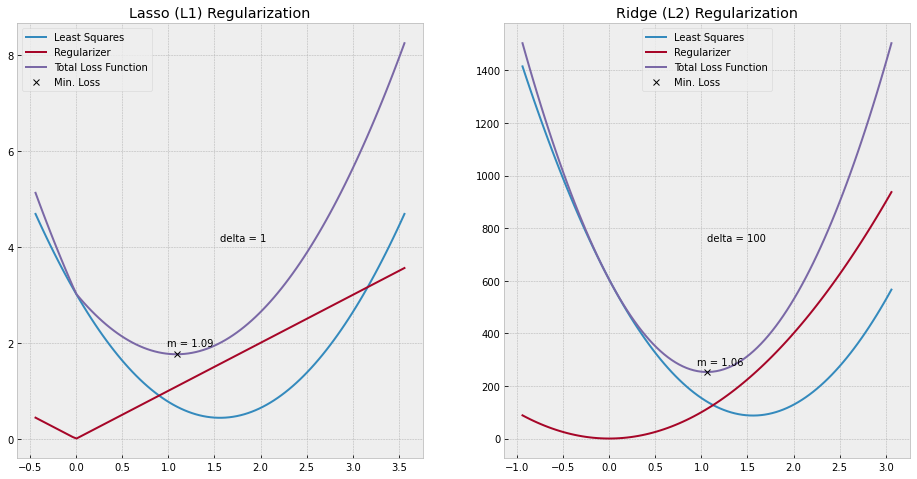

In [11]:
delta = 1

# Getting slope and intercept values from a regular linear regression
m, b = np.polyfit(x, y, 1)

# creating a set of theta values around the coefficient values
theta = np.linspace(m-2, m+2, 100)

x_norm = x - x.mean()
y_norm = y - y.mean()

#######################################################
# Lasso Regularization
#######################################################
# Least squares
z1 = 0
for i in range(len(x_norm)):
    z1 += (y_norm[i] - x_norm[i] * theta)**2
    
# Dividing by constant to get consistent results with scikit-learn Lasso
z1 = z1/(2*len(x_norm))

# L1 Regularizer
z2 = delta * np.abs(theta)

# Total loss function
z3 = z1 + z2

# Calculate slope (m) from scikit-learn Lasso
regr = Lasso(alpha = delta)
regr.fit(x.reshape(-1, 1), y)
m = regr.coef_[0]

plt.close()

fig, axs = plt.subplots(1, 2, figsize = (16, 8))
ax = axs[0]
ax.plot(theta, z1, label = 'Least Squares')
ax.plot(theta, z2, label = 'Regularizer')
ax.plot(theta, z3, label = 'Total Loss Function')
ax.plot(m, min(z3), 'kx', label = 'Min. Loss')
ax.set_title('Lasso (L1) Regularization')
ax.text(x = 0.9 * m, y = 1.1 * min(z3), s = 'm = {:.2f}'.format(m))
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
ax.text((x_min + x_max)/2, (y_min + y_max)/2, 'delta = {}'.format(delta))
ax.legend()

#######################################################
# Ridge (L2) Regularization
#######################################################
delta = 100 * delta

# Calculate slope (m) from scikit-learn Ridge
regr = Ridge(alpha = delta)
regr.fit(x.reshape(-1, 1), y)
mr = regr.coef_[0]

theta = np.linspace(mr-2, mr+2, 100)
z1 = 0
for i in range(x_norm.shape[0]):
    z1 += (y_norm[i] - x_norm[i]*theta) **2

z2 = delta * (theta**2)

z3 = z1 + z2

ax = axs[1]
ax.plot(theta, z1, label = 'Least Squares')
ax.plot(theta, z2, label = 'Regularizer')
ax.plot(theta, z3, label = 'Total Loss Function')
ax.plot(mr, min(z3), 'kx', label = 'Min. Loss')
ax.set_title('Ridge (L2) Regularization')
ax.text(x = 0.9 * mr, y = 1.1 * min(z3), s = 'm = {:.2f}'.format(mr))
ax.legend()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
ax.text((x_min + x_max)/2, (y_min + y_max)/2, 'delta = {}'.format(delta))
plt.show()

In [12]:
@interact(delta = widgets.FloatSlider(min = 0.2, max = 5, step = 0.2, value = 0.2, description = '\u03B4\u00B2'))
def plot_cost_fun(delta):
# Getting slope and intercept values from a regular linear regression
    m, b = np.polyfit(x, y, 1)

    # creating a set of theta values around the coefficient values
    theta = np.linspace(m-2, m+2, 100)

    x_norm = x - x.mean()
    y_norm = y - y.mean()

    #######################################################
    # Lasso Regularization
    #######################################################
    # Least squares
    z1 = 0
    for i in range(len(x_norm)):
        z1 += (y_norm[i] - x_norm[i] * theta)**2

    # Dividing by constant to get consistent results with scikit-learn Lasso
    z1 = z1/(2*len(x_norm))

    # L1 Regularizer
    z2 = delta * np.abs(theta)

    # Total loss function
    z3 = z1 + z2

    # Calculate slope (m) from scikit-learn Lasso
    regr = Lasso(alpha = delta)
    regr.fit(x.reshape(-1, 1), y)
    m = regr.coef_[0]

    plt.close()

    fig, axs = plt.subplots(1, 2, figsize = (16, 8))
    ax = axs[0]
    ax.plot(theta, z1, label = 'Least Squares', color = 'black')
    ax.plot(theta, z2, label = 'Regularizer', color = 'red')
    ax.plot(theta, z3, label = 'Total Loss Function', color = 'blue')
    ax.plot(m, min(z3), 'kx', label = 'Min. Loss')
    ax.set_title('Lasso (L1) Regularization, \u03B4\u00B2 = {:.2f}'.format(delta))
    ax.text(x = 0.9 * m, y = 1.1 * min(z3), s = 'm = {:.1f}'.format(m))
    ax.set_ylim(0, 10)
    ax.set_xlim(-0.5, 3.5)
    ax.set_xlabel('\u03B4\u00B2')
    ax.legend(loc = 2)

    #######################################################
    # Ridge (L2) Regularization
    #######################################################
    delta = 100 * delta

    # Calculate slope (m) from scikit-learn Ridge
    regr = Ridge(alpha = delta)
    regr.fit(x.reshape(-1, 1), y)
    mr = regr.coef_[0]

    theta = np.linspace(mr-2, mr+2, 100)
    z1 = 0
    for i in range(x_norm.shape[0]):
        z1 += (y_norm[i] - x_norm[i]*theta) **2

    z2 = delta * (theta**2)

    z3 = z1 + z2

    ax = axs[1]
    ax.plot(theta, z1, label = 'Least Squares', color = 'black')
    ax.plot(theta, z2, label = 'Regularizer', color = 'red')
    ax.plot(theta, z3, label = 'Total Loss Function', color = 'blue')
    ax.plot(mr, min(z3), 'kx', label = 'Min. Loss')
    ax.set_title('Ridge (L2) Regularization, \u03B4\u00B2 = {:.1f}'.format(delta))
    ax.text(x = 0.9 * mr, y = 1.1 * min(z3), s = 'm = {:.2f}'.format(mr))
    ax.set_xlabel('\u03B4\u00B2')
    ax.set_ylim(0, 1000)
    ax.set_xlim(-0.5, 2.5)
    ax.legend(loc = 2)
    
    plt.show()

interactive(children=(FloatSlider(value=0.2, description='δ²', max=5.0, min=0.2, step=0.2), Output()), _dom_cl…

### Notes:
* The least squares functions are different for Ridge and Lasso classes in scikit-learn (The difference is a constant multiplier ex: 1/2n for Lasso).
* Coefficients are zero for many $\delta^{2}$ values when using Lasso regularization, which is why it is prefered (excludes features).

### Linear regression with Lasso (L1) for bivariate case:

Comparing `Scikit-learn` Lasso results with `lasso_regr` results

Scikit-learn Lasso:
m1 = 1.5446634538883397  m2 = 0.03417619199134176  b = 4.294018620257042

My Lasso:
m1 = 1.5446634538883486  m2 = 0.03417619199134138  b = 4.294018620257021


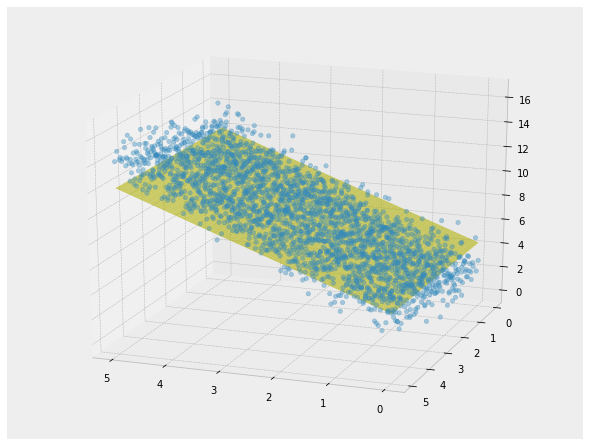

In [13]:
delta = 1

n = 50

X = np.linspace(0, 5, n)
X, Y = np.meshgrid(X, X)

Z = 2*X + 0.5*Y + 2 + np.random.randn(n, n)

regr = Lasso(alpha = delta)
X1 = np.zeros((n**2, 2))
X1[:, 0] = X.flatten()
X1[:, 1] = Y.flatten()

regr.fit(X1, Z.flatten())

m1s, m2s = regr.coef_
bs = regr.intercept_
print('Scikit-learn Lasso:')
print('m1 =', m1s, ' m2 =', m2s, ' b =', bs)

theta_init = np.random.rand(2)
m1, m2, b = lasso_regr(X1, Z.flatten(), theta_init, delta, tolerance = 1e-5)
print('\nMy Lasso:')
print('m1 =', m1, ' m2 =', m2, ' b =', b)

plt.close()
fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([0, 0, 1, 1], projection = '3d')
ax.scatter(X, Y, Z, alpha = 0.4)

Z1 = m1s*X + m2s*Y + bs
ax.plot_surface(X, Y, Z1, color = 'y', alpha = 0.6)
ax.azim = 110
ax.elev = 20
plt.show()

### Visualizing L1 regularized least squares cost function

In [14]:
n = 100

t1 = np.linspace(-1, 3, n)
t2 = np.linspace(-3, 3, n)

t1, t2 = np.meshgrid(t1, t2)

J1 = np.zeros((n, n))

X_norm1 = X1[:, 0] - X1[:, 0].mean()
X_norm2 = X1[:, 1] - X1[:, 1].mean()
Z_norm = Z.flatten() - Z.flatten().mean()

for i in range(X_norm1.shape[0]):
    J1 += (1/(2*X_norm1.shape[0])) * (Z_norm[i] - X_norm1[i]*t1 - X_norm2[i]*t2) **2

J2 = delta * (np.abs(t1) + np.abs(t2))

J = J1 + J2

fig = make_subplots(rows=1, cols=2, specs = [[{'type': 'surface'}, {'type': 'surface'}]])
surface1 = go.Surface(x = t1, y = t2, z = J1, showscale = False, colorscale = 'Hot')
surface2 = go.Surface(x = t1, y = t2, z = J2, showscale = False, colorscale = 'Greys')
surface3 = go.Surface(x = t1, y = t2, z = J, showscale = False)
fig.add_trace(surface1, row = 1, col = 1)
fig.add_trace(surface2, row = 1, col = 1)
fig.add_trace(surface3, row = 1, col = 2)

